# Explore PRIMAP emissions data

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = Path(os.path.abspath("../data/processed/"))

In [3]:
df = pd.read_csv(data_dir / "primap-histtp-ghg-without-lulucf-1850-2023.csv")

In [4]:
df.head()

,iso3,year,emissions_gt
0,ABW,1850,6.510000e-07
1,ABW,1851,6.580000e-07
2,ABW,1852,6.660000e-07
3,ABW,1853,6.780000e-07
4,ABW,1854,6.900000e-07


# 1. Who are the current top 5 emitters?

- [Historical trend and drivers of China’s CO2 emissions from 2000 to 2020](https://link.springer.com/article/10.1007/s10668-022-02811-8)
- [emissions declined after the fall of the Soviet Union](https://www.nature.com/articles/d41586-019-02024-6)

In [5]:
# filter out custom groups
custom_groups = [
    'EARTH',
    'ANNEXI',
    'NONANNEXI',
    'AOSIS',
    'BASIC',
    'EU27BX',
    'LDC',
    'UMBRELLA',
]

filt = ~(df['iso3'].isin(custom_groups))
df = df.loc[filt]

In [6]:
df.loc[df['year'] == 2021].sort_values(by='emissions_gt',ascending=False)[0:5]

,iso3,year,emissions_gt
6957,CHN,2021,14.70
35319,USA,2021,6.02
15483,IND,2021,4.05
28185,RUS,2021,2.63
5391,BRA,2021,1.30


In [7]:
top5 = list(df.loc[df['year'] == 2021].sort_values(by='emissions_gt',ascending=False)[0:5]['iso3'])

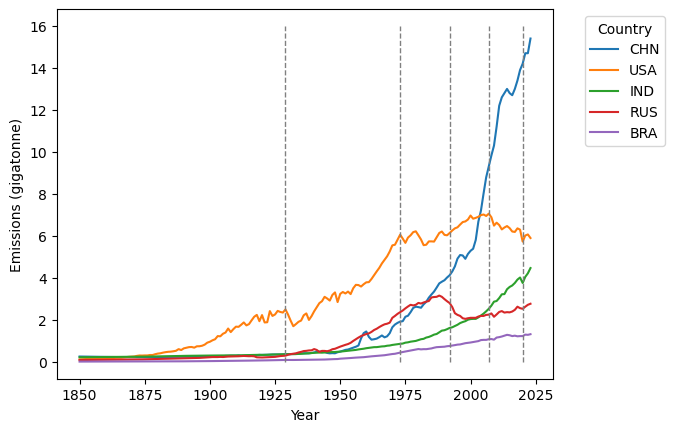

In [8]:
for party in top5:
    data = df.loc[df['iso3'] == party]
    plt.plot(data['year'], data['emissions_gt'], label=party)

plt.xlabel('Year')
plt.ylabel('Emissions (gigatonne)')

plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# fall of the soviet union
plt.plot([1992, 1992], [0, 16], '--', linewidth=1, color=[0.5,0.5,0.5])

# great depression
plt.plot([1929, 1929], [0, 16], '--', linewidth=1, color=[0.5,0.5,0.5])

# oil shock
plt.plot([1973, 1973], [0, 16], '--', linewidth=1, color=[0.5,0.5,0.5])

# financial crisis
plt.plot([2007, 2007], [0, 16], '--', linewidth=1, color=[0.5,0.5,0.5])

# covid pandemic
plt.plot([2020, 2020], [0, 16], '--', linewidth=1, color=[0.5,0.5,0.5])

# 2. Plot cumulative emissions
Things to notice:
- US is repsonible for majority of emissions. This tells a differnt story from the previous figure

In [9]:
df = df.assign(emissions_cumulative = df.groupby('iso3')['emissions_gt'].cumsum())

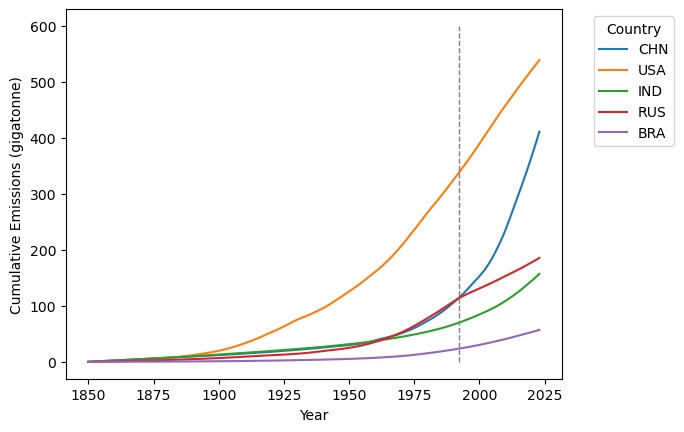

In [10]:
for party in top5:
    data = df.loc[df['iso3'] == party]
    plt.plot(data['year'], data['emissions_cumulative'], label=party)

plt.xlabel('Year')
plt.ylabel('Cumulative Emissions (gigatonne)')

plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# fall of the soviet union
plt.plot([1992, 1992], [0, 600], '--', linewidth=1, color=[0.5,0.5,0.5])

# 3 Plot UK emissions
- Rapid decrease in recent history most likely due to [phase out of coal power plants](https://interactive.carbonbrief.org/coal-phaseout-UK/)

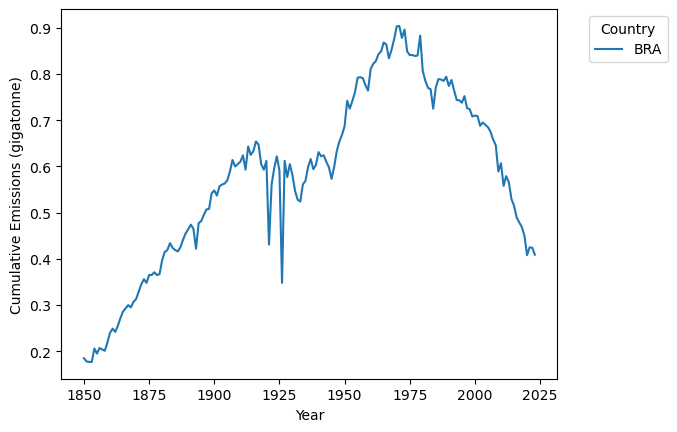

In [11]:
data = df.loc[df['iso3'] == "GBR"]
plt.plot(data['year'], data['emissions_gt'], label=party)

plt.xlabel('Year')
plt.ylabel('Cumulative Emissions (gigatonne)')

plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4 Are countries on track to meeting their NDC goals?
UK has a goal of "reducing economy-wide greenhouse gas emissions by at least 68%
by 2030, compared to 1990 levels." (see their [NDC](https://unfccc.int/sites/default/files/NDC/2022-09/UK%20NDC%20ICTU%202022.pdf))

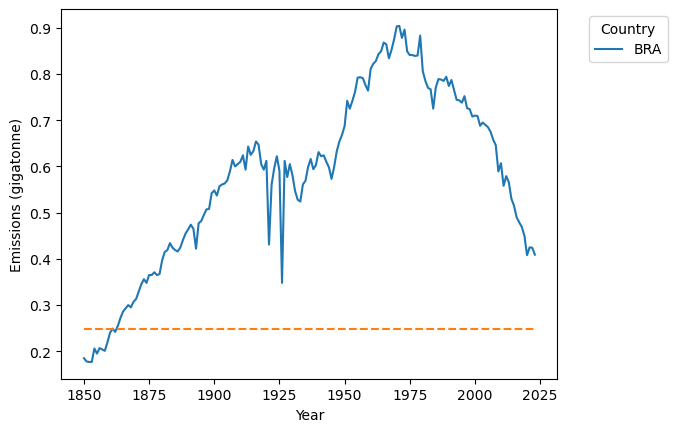

In [12]:
# raw data
data = df.loc[df['iso3'] == "GBR"]

# analysis
base_year = 1990
percent = 0.68
baseline_emissions = data.loc[data["year"] == base_year, "emissions_gt"].item()
target_emissions = baseline_emissions * (1 - percent)

# plot data
plt.plot(data['year'], data['emissions_gt'], label=party)
plt.plot([1850, 2023], [target_emissions, target_emissions], '--')

plt.xlabel('Year')
plt.ylabel('Emissions (gigatonne)')

plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

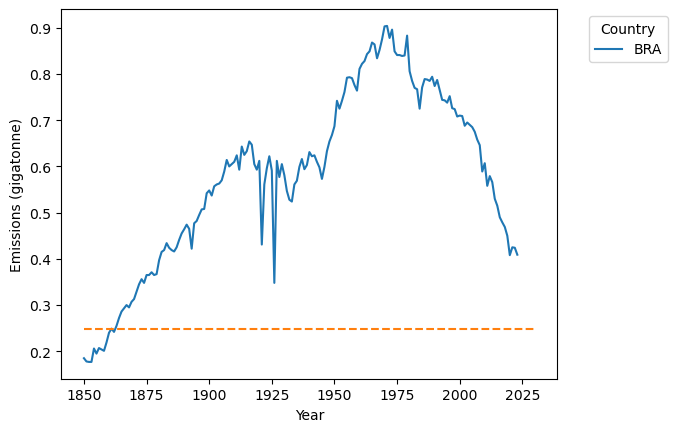

In [13]:
# raw data
data = df.loc[df['iso3'] == "GBR"]

# analysis
base_year = 1990
target_year = 2030
percent = 0.68
base_emissions = data.loc[data["year"] == base_year, "emissions_gt"].item()
target_emissions = base_emissions * (1 - percent)

# plot data
plt.plot(data['year'], data['emissions_gt'], label=party)
plt.plot([1850, target_year], [target_emissions, target_emissions], '--')

plt.xlabel('Year')
plt.ylabel('Emissions (gigatonne)')

plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

In [14]:
# year emissions peaked
peak_emissions = data['emissions_gt'].max()
peak_year = data.loc[data['emissions_gt'] == peak_emissions, 'year'].item()
print(f"Emissions peaked in {peak_year} at {peak_emissions} Gt")

Emissions peaked in 1971 at 0.904 Gt


# 5. Is GB on track to meet their goal? 
## assume linear reduction

In [15]:
def linear_eq(df, start_year=None, year_var='year', emissions_var='emissions_gt'):
    '''implementation of normal equations for ordinary least squares regression'''
    filt = df[year_var]>=start_year
    x = df.loc[filt, year_var].values
    y = df.loc[filt, emissions_var].values

    # least-squares linear regression
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(x * y)
    sum_xx = np.sum(x * x)
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    # calculate coefficients
    b = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2)
    a = mean_y - b * mean_x

    # Make predictions using the regression line
    pred = lambda x: a + b * x
    return {'equation':pred, 'slope':b, 'intercept':a}

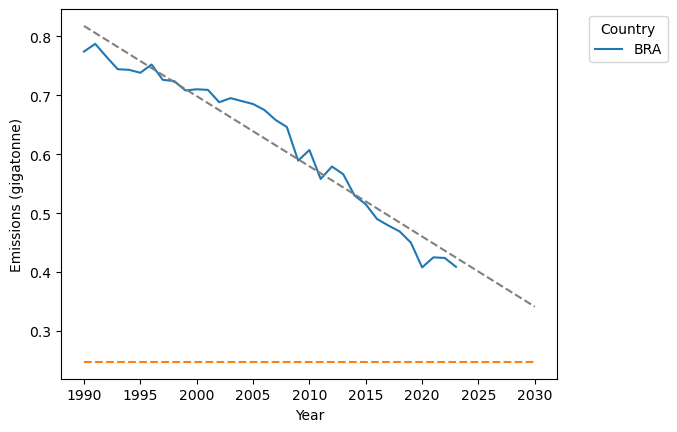

In [16]:
# raw data
data = df.loc[(df['iso3'] == "GBR") & (df['year']>=1990)]

# analysis
base_year = 1990
target_year = 2030
percent = 0.68
baseline_emissions = data.loc[data["year"] == base_year, "emissions_gt"].item()
target_emissions = baseline_emissions * (1 - percent)

# linear fit
pred = linear_eq(data, start_year=base_year)
X_pred = np.arange(base_year, target_year + 1)
Y_pred = pred['equation'](X_pred)

# plot data
plt.plot(data['year'], data['emissions_gt'], label=party)
plt.plot([base_year, target_year], [target_emissions, target_emissions], '--')

# plotlinear reduction
plt.plot(X_pred, Y_pred, '--', color=[0.5,0.5,0.5])

plt.xlabel('Year')
plt.ylabel('Emissions (gigatonne)')

plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')